In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [52]:
yt2018 = pd.read_csv(r"C:\Users\dell\OneDrive\Desktop\Imarticus_ContentAi\Table data 2018.csv")
yt2019 = pd.read_csv(r"C:\Users\dell\OneDrive\Desktop\Imarticus_ContentAi\Table data 2019.csv")
yt2020 = pd.read_csv(r"C:\Users\dell\OneDrive\Desktop\Imarticus_ContentAi\Table data 2020.csv")

print(yt2018.shape, yt2019.shape, yt2020.shape)
yt2018.head()

(134, 20) (502, 20) (502, 20)


,Date,Av­er­age views per view­er,Unique view­ers,Im­pres­sions click-through rate (%),Im­pres­sions,Com­ments ad­ded,Shares,Likes (vs. dis­likes) (%),Dis­likes,Sub­scribers lost,Sub­scribers gained,Likes,Av­er­age per­cent­age viewed (%),Videos pub­lished,Videos ad­ded,Sub­scribers,Views,Watch time (hours),Av­er­age view dur­a­tion,Your es­tim­ated rev­en­ue (USD)
0,Total,0.0000,0,11.50,101420,165,50,94.05,31,41,379,490,29.58,6.0,11.0,338,15053,519.9035,0:02:04,0
1,2018-08-21,1.1538,13,7.38,122,2,1,100.00,0,0,5,5,53.59,1.0,1.0,5,15,0.4666,0:01:51,0
2,2018-08-22,1.1935,31,23.14,121,3,0,100.00,0,2,6,4,44.58,NaN,NaN,4,37,0.9575,0:01:33,0
3,2018-08-23,1.3684,19,20.65,92,1,0,100.00,0,0,2,5,38.75,NaN,NaN,2,26,0.5849,0:01:20,0
4,2018-08-24,1.0000,8,13.64,44,0,0,NaN,0,0,0,0,24.81,NaN,NaN,0,8,0.1152,0:00:51,0


In [53]:
yt = pd.concat([yt2018, yt2019, yt2020], ignore_index=True)

print("Original columns:")
print(yt.columns.tolist())

Original columns:
['Date', 'Av\xader\xadage views per view\xader', 'Unique view\xaders', 'Im\xadpres\xadsions click-through rate (%)', 'Im\xadpres\xadsions', 'Com\xadments ad\xadded', 'Shares', 'Likes (vs. dis\xadlikes) (%)', 'Dis\xadlikes', 'Sub\xadscribers lost', 'Sub\xadscribers gained', 'Likes', 'Av\xader\xadage per\xadcent\xadage viewed (%)', 'Videos pub\xadlished', 'Videos ad\xadded', 'Sub\xadscribers', 'Views', 'Watch time (hours)', 'Av\xader\xadage view dur\xada\xadtion', 'Your es\xadtim\xadated rev\xaden\xadue (USD)']


In [54]:
import unicodedata
import re

def clean_col(col):
    # 1) Remove weird unicode like Â, soft hyphens, etc.
    col = unicodedata.normalize("NFKD", col)
    col = col.encode("ascii", "ignore").decode("ascii")

    # 2) Replace non-breaking spaces etc. with normal space
    col = col.replace("\u00a0", " ")

    # 3) Lowercase + strip
    col = col.strip().lower()

    # 4) Replace special chars
    col = col.replace("%", " pct")
    col = col.replace("(", "").replace(")", "")
    col = col.replace("/", " per ")

    # 5) Collapse multiple spaces to single underscore
    col = re.sub(r"\s+", "_", col)

    return col

# Apply to your dataframe
yt.columns = [clean_col(c) for c in yt.columns]

yt.columns.tolist()

['date',
 'average_views_per_viewer',
 'unique_viewers',
 'impressions_click-through_rate_pct',
 'impressions',
 'comments_added',
 'shares',
 'likes_vs._dislikes_pct',
 'dislikes',
 'subscribers_lost',
 'subscribers_gained',
 'likes',
 'average_percentage_viewed_pct',
 'videos_published',
 'videos_added',
 'subscribers',
 'views',
 'watch_time_hours',
 'average_view_duration',
 'your_estimated_revenue_usd']

In [55]:
# 1) Convert to datetime
yt["date"] = pd.to_datetime(yt["date"], errors="coerce")

# 2) Drop invalid dates (like "Total" row)
yt = yt[yt["date"].notna()].copy()

# 3) Now safely use .dt
yt["year"] = yt["date"].dt.year
yt["month"] = yt["date"].dt.month
yt["day"] = yt["date"].dt.day
yt["dayofweek"] = yt["date"].dt.dayofweek    # 0=Mon, 6=Sun
yt["is_weekend"] = yt["dayofweek"].isin([5, 6]).astype(int)

# Quick preview (only columns that exist)
cols_to_show = [c for c in ["date", "views", "impressions", "videos_published", "watch_time_hours"] if c in yt.columns]
yt[cols_to_show].head()

C:\Users\dell\AppData\Local\Temp\ipykernel_27192\3317175497.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  yt["date"] = pd.to_datetime(yt["date"], errors="coerce")


,date,views,impressions,videos_published,watch_time_hours
1,2018-08-21,15.0,122.0,1.0,0.4666
2,2018-08-22,37.0,121.0,NaN,0.9575
3,2018-08-23,26.0,92.0,NaN,0.5849
4,2018-08-24,8.0,44.0,NaN,0.1152
5,2018-08-25,17.0,72.0,NaN,0.4491


In [56]:
yt.columns.tolist()

['date',
 'average_views_per_viewer',
 'unique_viewers',
 'impressions_click-through_rate_pct',
 'impressions',
 'comments_added',
 'shares',
 'likes_vs._dislikes_pct',
 'dislikes',
 'subscribers_lost',
 'subscribers_gained',
 'likes',
 'average_percentage_viewed_pct',
 'videos_published',
 'videos_added',
 'subscribers',
 'views',
 'watch_time_hours',
 'average_view_duration',
 'your_estimated_revenue_usd',
 'year',
 'month',
 'day',
 'dayofweek',
 'is_weekend']

In [57]:
#Convert % columns to numeric Many YouTube exports store percentages as text (like "5.4%").
percent_cols = [
    "impressions_click_through_rate_pct",
    "likes_vs_dislikes_pct",
    "average_percentage_viewed_pct"
]

for col in percent_cols:
    if col in yt.columns:
        yt[col] = yt[col].astype(str).str.replace("%", "", regex=False)
        yt[col] = pd.to_numeric(yt[col], errors="coerce")

yt[[c for c in percent_cols if c in yt.columns]].head()

,average_percentage_viewed_pct
1,53.59
2,44.58
3,38.75
4,24.81
5,45.50


In [58]:
#Convert other numeric columns

num_cols = [
    "average_views_per_viewer",
    "unique_viewers",
    "impressions",
    "comments_added",
    "shares",
    "dislikes",
    "subscribers_lost",
    "subscribers_gained",
    "likes",
    "videos_published",
    "videos_added",
    "subscribers",
    "views",
    "watch_time_hours",
    "average_view_duration",
    "your_estimated_revenue_usd"
]

for col in num_cols:
    if col in yt.columns:
        yt[col] = pd.to_numeric(yt[col], errors="coerce")

yt[["views", "impressions", "watch_time_hours"]].head()


,views,impressions,watch_time_hours
1,15.0,122.0,0.4666
2,37.0,121.0,0.9575
3,26.0,92.0,0.5849
4,8.0,44.0,0.1152
5,17.0,72.0,0.4491


In [59]:
#Building the daily views prediction model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Keep only rows that have views
data = yt.dropna(subset=["views"]).copy()

all_feature_candidates = [
    "impressions",
    "impressions_click_through_rate_pct",
    "videos_published",
    "average_views_per_viewer",
    "average_percentage_viewed_pct",
    "watch_time_hours",
    "subscribers",
    "dayofweek",
    "month",
    "is_weekend"
]

# Use only the ones that actually exist in your dataframe
feature_cols = [c for c in all_feature_candidates if c in yt.columns]

print("Using features:", feature_cols)

X = data[feature_cols].fillna(0)
y = data["views"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_views = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

model_views.fit(X_train, y_train)

y_pred = model_views.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)  # this returns MSE
rmse = mse ** 0.5                         # take square root to get RMSE
r2 = r2_score(y_test, y_pred)

print(f"Views model - MAE : {mae:,.2f}")
print(f"Views model - RMSE: {rmse:,.2f}")
print(f"Views model - R²  : {r2:.3f}")

Using features: ['impressions', 'videos_published', 'average_views_per_viewer', 'average_percentage_viewed_pct', 'watch_time_hours', 'subscribers', 'dayofweek', 'month', 'is_weekend']
Views model - MAE : 1,968.17
Views model - RMSE: 7,300.42
Views model - R²  : 0.994


dayofweek
6    55813.092593
5    53414.160494
3    52978.123457
4    52688.987654
1    51933.907407
2    51208.870370
0    45419.968944
Name: views, dtype: float64


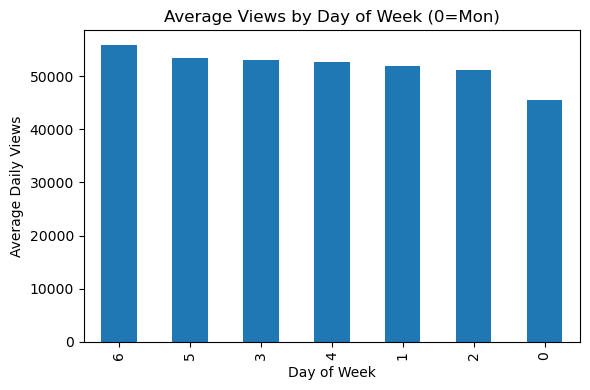

In [60]:
views_by_dow = data.groupby("dayofweek")["views"].mean().sort_values(ascending=False)
print(views_by_dow)

plt.figure(figsize=(6,4))
views_by_dow.plot(kind="bar")
plt.title("Average Views by Day of Week (0=Mon)")
plt.ylabel("Average Daily Views")
plt.xlabel("Day of Week")
plt.tight_layout()
plt.show()

watch_time_hours                 0.743600
impressions                      0.199475
subscribers                      0.052260
average_views_per_viewer         0.001826
dayofweek                        0.001059
average_percentage_viewed_pct    0.000989
videos_published                 0.000364
is_weekend                       0.000222
month                            0.000207
dtype: float64


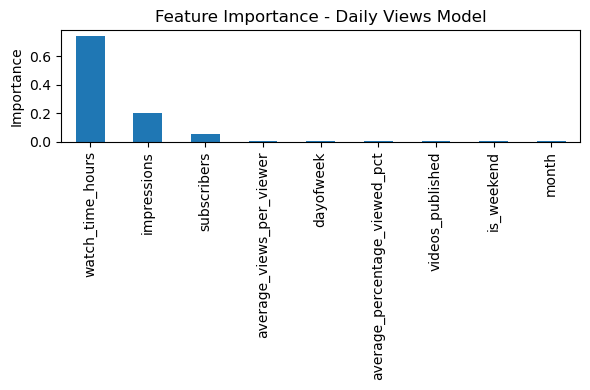

In [61]:
#Feature importance (Explainability)
feat_imp_views = pd.Series(
    model_views.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

print(feat_imp_views)

plt.figure(figsize=(6,4))
feat_imp_views.plot(kind="bar")
plt.title("Feature Importance - Daily Views Model")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [63]:
# WEEKLY CONTENT STRATEGY HELPER
# ==============================

def suggest_youtube_posting_days(df, n_days=3):
    """
    Suggest best posting days based on historical average views.
    
    Parameters:
        df     : pandas DataFrame with at least 'dayofweek' and 'views' columns
        n_days : how many top days to return (default 3)
    
    Returns:
        views_by_dow : Series of average views per dayofweek (0=Mon,...,6=Sun)
        top_days     : list of day names, e.g. ['Wed', 'Sat', 'Sun']
    """
    
    dow_map = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
    
   
    views_by_dow = df.groupby("dayofweek")["views"].mean().sort_values(ascending=False)
    
    
    top_days_idx = views_by_dow.head(n_days).index.tolist()
    top_days = [dow_map[i] for i in top_days_idx]
    
    return views_by_dow, top_days


views_by_dow, best_days = suggest_youtube_posting_days(data)

print("Average views by day-of-week (0=Mon,...,6=Sun):")
print(views_by_dow)
print("\nSuggested posting days (top 3):", best_days)

Average views by day-of-week (0=Mon,...,6=Sun):
dayofweek
6    55813.092593
5    53414.160494
3    52978.123457
4    52688.987654
1    51933.907407
2    51208.870370
0    45419.968944
Name: views, dtype: float64

Suggested posting days (top 3): ['Sun', 'Sat', 'Thu']


In [64]:
#build a simple weekly content plan
def build_weekly_content_plan(best_days, videos_per_week=4):
    """
    Creates a simple weekly content plan based on best posting days.
    
    Parameters:
        best_days       : list of best day names, e.g. ['Wed', 'Sat', 'Sun']
        videos_per_week : how many videos creator wants to publish per week
    
    Returns:
        dict: { 'Mon': 0/1/2 videos, ... }
    """
    all_days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    plan = {day: 0 for day in all_days}
    
    
    i = 0
    for _ in range(videos_per_week):
        day = best_days[i % len(best_days)]
        plan[day] += 1
        i += 1
    
    return plan

weekly_plan = build_weekly_content_plan(best_days, videos_per_week=4)
print("\nSimple weekly content plan (videos per day):")
for day, count in weekly_plan.items():
    print(f"{day}: {count} video(s)")


Simple weekly content plan (videos per day):
Mon: 0 video(s)
Tue: 0 video(s)
Wed: 0 video(s)
Thu: 1 video(s)
Fri: 0 video(s)
Sat: 1 video(s)
Sun: 2 video(s)


In [65]:
# TITLE SCORING & A/B OPTIMIZER
import re

power_phrases = [
    "how to", "guide", "tips", "mistakes", "secrets",
    "strategy", "step by step", "tutorial", "for beginners"
]

def score_title(title, main_keyword=None):
    """
    Heuristic scoring function for YouTube titles.
    Higher score = potentially better title.
    
    Factors:
    - Length in a good range (~40-70 chars)
    - Contains a number
    - Contains a 'power phrase'
    - Contains main keyword
    """
    t = str(title).strip()
    t_lower = t.lower()
    score = 0
    
    
    length = len(t)
    # Ideal range ~ 40-70 characters
    if 40 <= length <= 70:
        score += 2
    elif 25 <= length < 40 or 70 < length <= 90:
        score += 1  # acceptable range
    
    
    if re.search(r"\d", t):
        score += 1
    
    
    if any(phrase in t_lower for phrase in power_phrases):
        score += 1
    
    
    if main_keyword and main_keyword.lower() in t_lower:
        score += 2
    
    return score

def compare_titles(title_a, title_b, main_keyword=None):
    """
    Compare two titles and recommend one based on heuristic scores.
    
    Returns:
        dict with both scores and recommended title.
    """
    score_a = score_title(title_a, main_keyword)
    score_b = score_title(title_b, main_keyword)
    
    if score_a > score_b:
        recommendation = "A"
    elif score_b > score_a:
        recommendation = "B"
    else:
        recommendation = "Tie"
    
    return {
        "title_a": {"title": title_a, "score": score_a},
        "title_b": {"title": title_b, "score": score_b},
        "recommendation": recommendation
    }

# Example usage:
example = compare_titles(
    "5 Mistakes New Data Scientists Make (Avoid These!)",
    "Data Science Tips for Beginners",
    main_keyword="data science"
)

print("A/B Title Comparison Example:")
print(example)

A/B Title Comparison Example:
{'title_a': {'title': '5 Mistakes New Data Scientists Make (Avoid These!)', 'score': 4}, 'title_b': {'title': 'Data Science Tips for Beginners', 'score': 4}, 'recommendation': 'Tie'}


In [66]:
# CONTENTPILOT AI – SIMPLE AGENT WRAPPER
# =======================================

def contentpilot_agent(
    target_videos_per_week=4,
    main_keyword="data science",
    candidate_titles=None
):
    """
    Simple agent-style wrapper that:
    1) Analyzes best posting days
    2) Builds a weekly content plan
    3) Scores candidate titles (if given)
    """
    print("🔎 Step 1: Analyzing historical performance...")
    views_by_dow, best_days = suggest_youtube_posting_days(data, n_days=3)
    print("\nAverage views by day-of-week:")
    print(views_by_dow)
    print("\n✅ Suggested best posting days:", best_days)

    print("\n🗓 Step 2: Building a weekly content plan...")
    weekly_plan = build_weekly_content_plan(best_days, videos_per_week=target_videos_per_week)
    print("\nWeekly content plan (videos per day):")
    for day, count in weekly_plan.items():
        print(f"  {day}: {count} video(s)")

    if candidate_titles:
        print("\n🧠 Step 3: Scoring candidate titles...")
        for t in candidate_titles:
            score = score_title(t, main_keyword=main_keyword)
            print(f"  \"{t}\"  -> score: {score}")

    print("\n🎯 Agent summary:")
    print(f"- Focus posting on: {', '.join(best_days)}")
    print(f"- Target {target_videos_per_week} videos per week")
    if candidate_titles:
        print("- Use the scores above to pick/iterate on stronger titles.")


candidate_titles_example = [
    "5 Mistakes New YouTubers Make (Avoid These!)",
    "YouTube Growth Guide for Beginners",
    "How to Plan 1 Week of Content in 30 Minutes"
]

contentpilot_agent(
    target_videos_per_week=4,
    main_keyword="youtube",
    candidate_titles=candidate_titles_example
)

🔎 Step 1: Analyzing historical performance...

Average views by day-of-week:
dayofweek
6    55813.092593
5    53414.160494
3    52978.123457
4    52688.987654
1    51933.907407
2    51208.870370
0    45419.968944
Name: views, dtype: float64

✅ Suggested best posting days: ['Sun', 'Sat', 'Thu']

🗓 Step 2: Building a weekly content plan...

Weekly content plan (videos per day):
  Mon: 0 video(s)
  Tue: 0 video(s)
  Wed: 0 video(s)
  Thu: 1 video(s)
  Fri: 0 video(s)
  Sat: 1 video(s)
  Sun: 2 video(s)

🧠 Step 3: Scoring candidate titles...
  "5 Mistakes New YouTubers Make (Avoid These!)"  -> score: 6
  "YouTube Growth Guide for Beginners"  -> score: 4
  "How to Plan 1 Week of Content in 30 Minutes"  -> score: 4

🎯 Agent summary:
- Focus posting on: Sun, Sat, Thu
- Target 4 videos per week
- Use the scores above to pick/iterate on stronger titles.
